In [2]:
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
gpt_summaries = pd.read_csv('summaries.csv')
llama_summaries = pd.read_csv('summaries (1).csv')
actual_summaries = pd.read_csv('Benefits Grid Summaries.csv')

In [69]:
gpt_summaries = gpt_summaries.rename(columns = {'County': 'county',
                                                'Provider': 'provider'})

In [70]:
actual_summaries['contract_plan'] = actual_summaries['contract_plan'].str.replace(' ', '')
actual_summaries['contract_plan'] = actual_summaries['contract_plan'].str.replace('-', '')
actual_summaries = actual_summaries[['county', 'provider', 'contract_plan', 'dental_notes']]

In [71]:
dataset = pd.merge(actual_summaries, gpt_summaries, how = 'inner', on = ['county', 'provider', 'contract_plan'])
dataset = dataset.drop_duplicates()

In [72]:
dataset['actual_tokens'] = dataset['dental_notes'].apply(lambda x: str(x).split())
dataset['gpt_tokens'] = dataset['Dental Summary'].apply(lambda x: str(x).split())

In [73]:
dataset['bleu_score'] = dataset.apply(lambda x : sentence_bleu(x['actual_tokens'], x['gpt_tokens']), axis=1)

/Users/britt/Documents/Northeastern/DS5500/Project/health-plan-comparison/.venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/britt/Documents/Northeastern/DS5500/Project/health-plan-comparison/.venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/britt/Documents/Northeastern/DS5500/Project/health-plan-comparison/.venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of

In [75]:
dataset['bleu_score_rounded'] = dataset.apply(lambda x : round(x['bleu_score'], 4), axis=1)

In [51]:
from sentence_transformers import SentenceTransformer, util

/Users/britt/Documents/Northeastern/DS5500/Project/health-plan-comparison/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [76]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [122]:
def cos_sim(sent1, sent2):
    embedding_1 = model.encode(str(sent1), convert_to_tensor = True)
    embedding_2 = model.encode(str(sent2), convert_to_tensor = True)
    score = util.pytorch_cos_sim(embedding_1, embedding_2)
    score = score.numpy()
    # score.replace('tensor(', '').replace(')', '')
    return score[0][0]

In [123]:
dataset['cos_sim'] = dataset.apply(lambda x : cos_sim(x['dental_notes'], x['Dental Summary']), axis = 1)

In [127]:
cos_sim = np.array(dataset['cos_sim'])

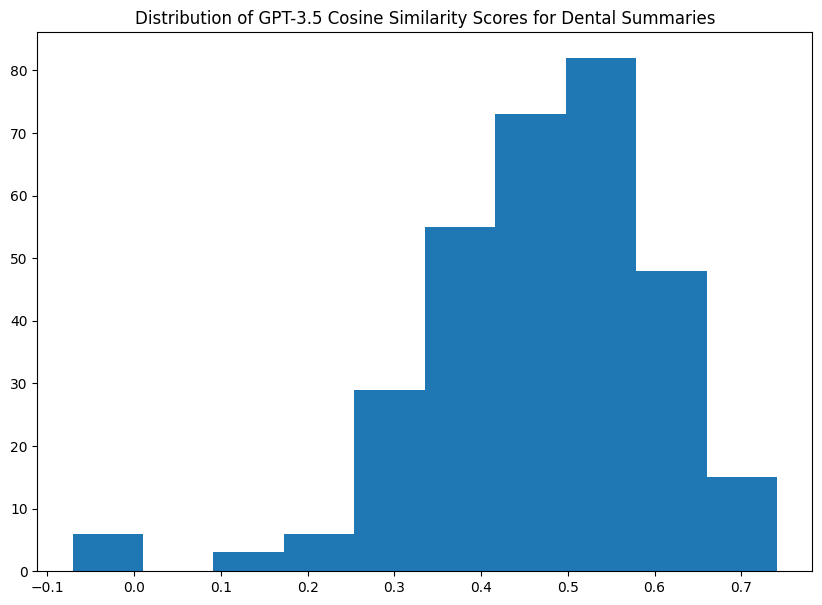

In [130]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(cos_sim, bins = 10)
plt.title('Distribution of GPT-3.5 Cosine Similarity Scores for Dental Summaries')
plt.show()

In [135]:
dataset.to_csv('gpt_cos_sim_score.csv')